In [1]:
%matplotlib notebook
%matplotlib inline

import os
os.environ['KERAS_BACKEND'] = "tensorflow" # you can use "cntk" or "tensorflow"
import time
import datetime as dt
import numpy as np
from numpy import newaxis
from numpy import array
import matplotlib.pyplot as plt
import pandas
from urllib.request import urlretrieve
import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load Microsoft (MSFT) stock data from Quandl

In [2]:
start_date = "2000-01-01"
end_date =   "2018-04-01"
stock = "MSFT"
order = "asc"
parameters = '?&start_date='+start_date+'&end_date='+end_date+'&order='+order
file = stock+".csv"

def download(url, file):
    """
    Download file from <url>
    :param url: URL to file
    :param file: Local file path
    """
    if not os.path.isfile(file):
        print('Downloading ' + url )
        urlretrieve(url, file)
        print('Download Finished')
    else:
        print('File is already on disk')

# Download  dataset.
download('https://www.quandl.com/api/v3/datasets/WIKI/' + stock + '.csv' + parameters, file)

File is already on disk


In [3]:
data = pandas.read_csv(file, index_col='Date')
# Converting the index as date
data.index = pandas.to_datetime(data.index)

In [4]:
data.describe()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
count,4586.000000,4586.000000,4586.000000,4586.000000,4.586000e+03,4586.000000,4586.000000,4586.000000,4586.000000,4586.000000,4586.000000,4.586000e+03
mean,40.286633,40.755574,39.826630,40.288769,5.135335e+07,0.003055,1.000218,29.078012,29.373682,28.787272,29.083795,5.799623e+07
std,18.614374,18.899496,18.321689,18.602692,2.875247e+07,0.051648,0.014767,16.089370,16.182702,15.986585,16.094881,3.166583e+07
min,15.200000,15.620000,14.870000,15.150000,5.850800e+06,0.000000,1.000000,12.154701,12.490554,11.890816,12.114718,7.425503e+06
25%,26.696250,26.930000,26.470000,26.690000,3.225230e+07,0.000000,1.000000,19.325016,19.554843,19.091851,19.325016,3.686569e+07
50%,30.300000,30.605000,30.055000,30.320000,4.675009e+07,0.000000,1.000000,22.564576,22.846906,22.354119,22.589808,5.290715e+07
75%,52.655000,53.496250,51.885000,52.735000,6.303825e+07,0.000000,1.000000,32.361858,32.704246,31.917774,32.314573,7.141460e+07
max,117.370000,118.620000,112.250000,116.560000,5.910522e+08,3.080000,2.000000,97.000000,97.240000,96.040000,96.770000,5.910522e+08


In [5]:
data.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2000-01-03,117.37,118.62,112.00,116.56,26614200.0,0.0,1.0,39.066089,39.482146,37.278708,38.796484,53228400.0
2000-01-04,113.56,117.12,112.25,112.62,27059500.0,0.0,1.0,37.797947,38.982878,37.361920,37.485073,54119000.0
2000-01-05,111.12,116.37,109.37,113.81,32029800.0,0.0,1.0,36.985804,38.733244,36.403324,37.881159,64059600.0
2000-01-06,112.19,113.87,108.37,110.00,27488300.0,0.0,1.0,37.341949,37.901130,36.070479,36.613017,54976600.0
2000-01-07,108.62,112.25,107.31,111.44,31006800.0,0.0,1.0,36.153690,37.361920,35.717662,37.092315,62013600.0


# Data Normalization and Columns pick

In [6]:
#normalise data
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler()
cols = ['Open','High','Low','Volume','Close']
#cols = ['Adj. Open','Adj. High','Adj. Low','Adj. Volume','Adj. Close']
df = pandas.DataFrame(scaler.fit_transform(data[cols]) , columns=cols, index=data.index, dtype="float32") #Normalize
df.head()

,Open,High,Low,Volume,Close
Date,,,,,
2000-01-03,1.000000,1.000000,0.997433,0.035481,1.000000
2000-01-04,0.962709,0.985437,1.000000,0.036242,0.961148
2000-01-05,0.938827,0.978155,0.970425,0.044735,0.972882
2000-01-06,0.949300,0.953883,0.960156,0.036974,0.935312
2000-01-07,0.914358,0.938155,0.949271,0.042987,0.949512


# Function to load/prepare data for modeling

In [7]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() #converts to numpy
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

# Function to define the RNN model

In [8]:
def build_model(moving_window, num_features):
        d = 0.3
        model = Sequential()
        model.add(LSTM(64, input_shape=(moving_window, num_features), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16, kernel_initializer="uniform", activation="relu"))
        model.add(Dense(1, kernel_initializer="uniform",activation='relu'))
        model.compile(loss='mse', optimizer='adam', metrics=['mae'])
        return model

# Run the model

In [9]:
window = 10
X_train, y_train, X_test, y_test = load_data(df[::-1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (4118, 10, 5)
y_train (4118,)
X_test (457, 10, 5)
y_test (457,)


In [10]:
model = build_model(window,len(X_train[0][0]))

In [11]:
# Verify the architecture 
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 18,977
Trainable params: 18,977
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
# checkpoint
SHARE_ROOT = "./stockdemo-model/"

# We'll serialize the model in json format
LSTM_MODEL = SHARE_ROOT + 'modellstm.json'

# and store the weights in h5
MODEL_WEIGHTS = SHARE_ROOT + 'modellstm.h5'  

checkpoint = keras.callbacks.ModelCheckpoint(MODEL_WEIGHTS, monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='min')

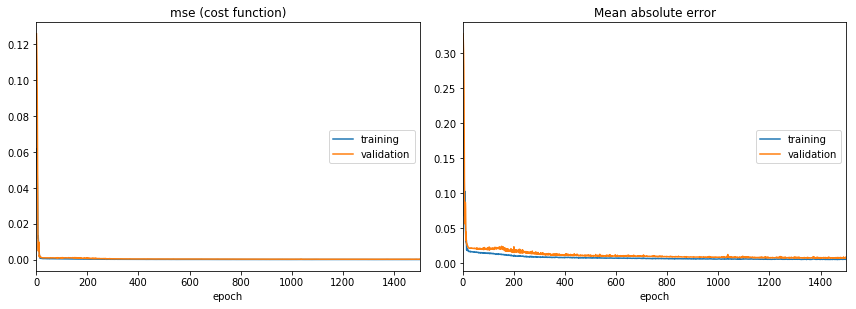


Epoch 01500: val_mean_absolute_error did not improve
CPU times: user 8min 38s, sys: 29.4 s, total: 9min 7s
Wall time: 8min 18s


In [13]:
%%time
from livelossplot import PlotLossesKeras

#Step 3 Train the model
history = model.fit(
    X_train,
    y_train,
    batch_size=1024,
    epochs=1500,
    validation_split=0.1,
    verbose=0,
    callbacks=[PlotLossesKeras(), checkpoint])

# Check and plot results

In [22]:
import math

trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.5f MSE (%.5f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.5f MSE (%.5f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.00005 MSE (0.00673 RMSE)
Test Score: 0.00049 MSE (0.02210 RMSE)


In [31]:
#bring the best weights and see test scores again

# load weights into new model
model.load_weights(MODEL_WEIGHTS)
print("Best Weights loaded")

trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.5f MSE (%.5f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.5f MSE (%.5f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Best Weights loaded
Train Score: 0.00005 MSE (0.00673 RMSE)
Test Score: 0.00049 MSE (0.02210 RMSE)


In [24]:
# print(X_test[-1])
yhat = model.predict(X_test)

In [25]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

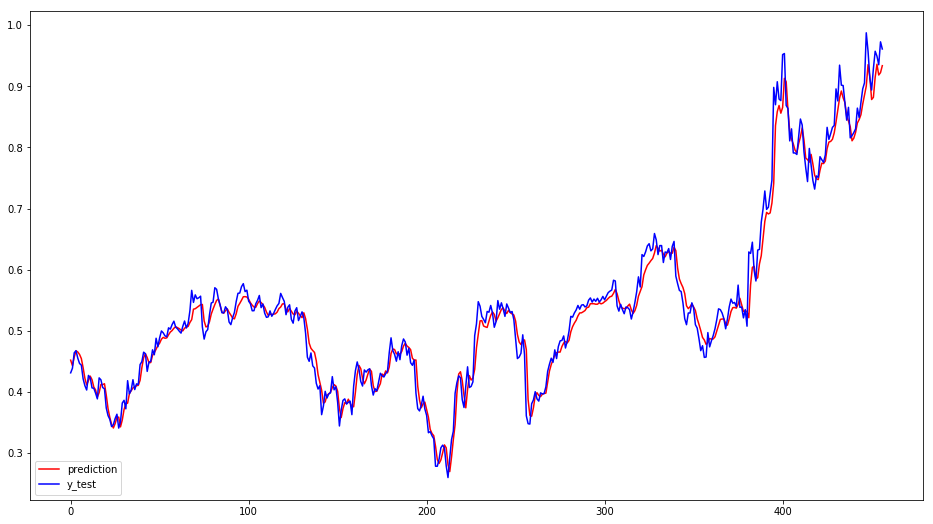

In [26]:
plt.rcParams["figure.figsize"] = [16,9]
plt.plot(yhat,color='red', label='prediction')
plt.plot(y_test,color='blue', label='y_test')
plt.legend(loc='lower left')
plt.show()

# Saving the model
The LSTM network is made up of two components, the architecture and the model weights. We'll save these model components in two files, the architecture in a json file that the keras package can use to rebuild the model, and the weights in an HDF5 heirachy that rebuild the exact model. We already has the best weights, so we only need to save the model.

In [28]:
import os
    
# save model
# serialize model to JSON
model_json = model.to_json()
with open(LSTM_MODEL, "w") as json_file:
    json_file.write(model_json)

print("Model saved")

Model saved


To test the save operations, we can reload the model files into a test model loaded_model and rescore the test dataset.

In [29]:
from keras.models import model_from_json

# load json and create model
json_file = open(LSTM_MODEL, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(MODEL_WEIGHTS)
print("Model loaded")

Model loaded


The model constructed from storage can be used to predict

In [30]:
test_row = X_test[:1]
print(test_row)
print(test_row.shape)
score = loaded_model.predict(test_row)
print(score.shape)
print(score)

[[[0.50504065 0.50805825 0.53121793 0.04140284 0.5201657 ]
  [0.48448664 0.49339807 0.5009242  0.03934645 0.49935904]
  [0.4809631  0.48572814 0.50359416 0.03102522 0.49363968]
  [0.48213762 0.48970875 0.5010269  0.0534228  0.48584953]
  [0.4797886  0.47990292 0.5048264  0.04032578 0.48417315]
  [0.46491143 0.47883496 0.48562333 0.04862463 0.48939946]
  [0.45668983 0.47       0.481413   0.04673605 0.47450942]
  [0.45737496 0.46019417 0.4686794  0.06122542 0.4560694 ]
  [0.43926787 0.45271844 0.45933455 0.08370588 0.46040824]
  [0.43163356 0.43796116 0.44393098 0.04528219 0.4240213 ]]]
(1, 10, 5)
(1, 1)
[[0.45194247]]


# So, where to go from here?

Well, as you can imagine, this is a simple MANY-TO-ONE prediction. The model is predicting the next Time Step by getting as input a window (sequence) of past measures.
This model can be improved by:
    1. Making the series stationary and using StandardScaler vs MaxMinScaler
    2. Predicting the next N steps (multi-step prediction) by using seq2seq models vs a simple RNN (like above)
    3. And the most important of all: Adding more signals/features/columns
